# 第3章 K近邻
## 概要
1. 给定的训练实例点和输入实例点，首先确定输入实例点的K个最近邻的训练实例点，然后用这K个训练实例点的类的多数来预测输入实例点。
2. K 近邻法中当训练集，距离度量、K值和分类决策规则确定后，其结果唯一。
3. 三要素：K值、距离度量、分类决策规则。常用的距离距离度量是欧式距离；K值小时，模型复杂，K值大时，模型简单；常用的分类决策规则是多数表决。
4. 实用kd树能快速搜索K个最近邻点。

## 距离度量
1. 设 x 是 n 维实数向量空间，则$x_i, x_j$ 间的距离公式:
$$L_p(x_i, x_j) = \sum_{l=1}^n \left(|x_i^l - x_j^l| ^p \right )^{\frac{1}{p}}$$
    - p=1时，曼哈顿距离
    - p=2时，欧式距离
    - p=∞时，切比雪夫距离

### 课本例3.1

In [26]:
import math
from itertools import combinations

In [3]:
def L(x, y, p=2):
    """
    距离计算公式
    """
    assert len(x) == len(y), 'x, y 长度不一致'
    if len(x) > 1:
        sum = 0
        for i in range(len(x)):
            sum += math.pow(abs(x[i] - y[i]), p)
        return math.pow(sum, 1 / p) 
    else:
        return 0

In [4]:
x1 = [1, 1]
x2 = [5, 1]
x3 = [4, 4]
for p in range(1, 5):
    r = {f'1-{c}': L(x1, c, p) for c in (x2, x3)}
    print(f'当p={p}', r)

当p=1 {'1-[5, 1]': 4.0, '1-[4, 4]': 6.0}
当p=2 {'1-[5, 1]': 4.0, '1-[4, 4]': 4.242640687119285}
当p=3 {'1-[5, 1]': 3.9999999999999996, '1-[4, 4]': 3.7797631496846193}
当p=4 {'1-[5, 1]': 4.0, '1-[4, 4]': 3.5676213450081633}


### 实例，遍历所有数据点，找到最近的k个点

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
%matplotlib inline

In [6]:
iris = load_iris()
x = iris.data[:100, :2]
y = iris.target[:100]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=9)

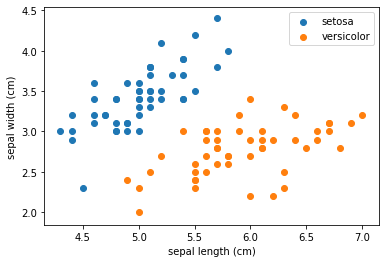

In [7]:
# 画图
plt.scatter(x[:50, 0], x[:50, 1], label=iris.target_names[0])
plt.scatter(x[50:100, 0], x[50:100, 1], label=iris.target_names[1])
# plt.scatter(x[100:150, 0], x[100:150, 1], label=iris.target_names[2])
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend()
plt.show()

In [8]:
class KNN:
    def __init__(self, x_train, y_train, n_neighbors=3, p=2):
        """
        parameter: n_neighbors，邻近点数量
        parameter: p 距离度量方式
        """
        self.n = n_neighbors
        self.p = p
        self.x_train = x_train
        self.y_train = y_train
        
    def predict(self, x):
        # 取出k个点
        knn_list = []
        for i in range(self.n):
            # 求范数，即距离度量
            dist = np.linalg.norm(x - self.x_train[i], ord=self.p)
            knn_list.append((dist, self.y_train[i]))
         
        # 遍历剩余点
        for i in range(self.n, len(self.x_train)):
            # 找到列表中距离度量最大值的索引
            max_index = knn_list.index(max(knn_list, key=lambda x: x[0]))
            dist = np.linalg.norm(x - self.x_train[i], ord=self.p)
            # 判断此距离与列表中最大的距离的大小
            if knn_list[max_index][0] > dist:
                knn_list[max_index] = (dist, self.y_train[i])
        
        # 统计结果，投票选择
        knn = [k[1] for k in knn_list]
        count_pairs = Counter(knn)
        max_count = max(count_pairs.items(), key=lambda x: x[1])[0]
        return max_count
    
    def score(self, x_test, y_test):
        right_count = 0
        for x, y in zip(x_test, y_test):
            label = self.predict(x)
            if label == y:
                right_count += 1
        return right_count / len(x_test)

In [9]:
knn = KNN(x_train, y_train, n_neighbors=4, p=1)
#     print(knn.predict(x_test[0]))
print(knn.score(x_test, y_test))

1.0


### sklearn API 实例

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# algorithm: K 近邻搜索方法
knn2 = KNeighborsClassifier(n_neighbors=4, p=1, algorithm='auto')
knn2.fit(x_train, y_train)
print(knn2.score(x_test, y_test))

1.0


## KD树的构建
1. kd树是一种对K维空间的实例点进行存储以便快速检索的树形数据结构
2. kd树是一个二叉树，表示对k维空间中的一个划分。
3. 构造方法：
    - 构造根节点，使根结点对应于$k$维空间中包含所有实例点的超矩形区域通过下面的递归方法
    - 不断地对$k$维空间进行切分，生成子结点。
    - 选择一个切分点，确定一个超平面，这个超平面的的节点垂直于选择的坐标轴，将当前超矩形划分为左右两个矩形
    - 通常选择实例点在坐标轴上的中位数作为切分点，这样得到的Kd树是平衡的

## 构造平衡kd树算法
1. 开始：构造根节点，选择$x^l$为坐标轴，以实例点中$x^l$的中位树为切分点，切分由通过切分点并于$x^l$轴垂直的超平面切分，落在切分平面上的点保存为根节点
2. 重复：直到子区域内没有实例点。

In [64]:
# kd-tree中包含的数据结构如下
class KdNode:
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt    # k维向量节点
        self.split = split        # 切分点
        self.left = left          # 该节点分给超平面左子空间构成的kd-tree
        self.right = right        # 右空间构成的kd-tree
        

class KdTree:
    def __init__(self, data):
        k = len(data[0])     # 实例点的维度
        
        def create_node(split, dataset):
            if not dataset:    # 数据集为空
                return None
            # 按第K维划分数据集，对数据集中的split进行排序
            dataset.sort(key=lambda x: x[split])
            split_pos = len(dataset) // 2
            median = dataset[split_pos]
            split_next = (split + 1) % k
            
            # 递归创建决策树
            return KdNode(
                median,
                split, 
                create_node(split_next, dataset[:split_pos]),
                create_node(split_next, dataset[split_pos + 1:]),
            )
        self.root = create_node(0, data)
        
# 前序遍历
def preorder(root):
    print(root.dom_elt)
    if root.left:
        print('左节点')
        preorder(root.left)
    if root.right:
        print('右节点')
        preorder(root.right)

### 搜索kd-tree
- 输入：已构造的kd树，目标点 x
- 输出：x的最近邻
- 步骤：
    1. 在kd树中找到包含目标点 x 的叶节点：从根节点出发，递归向下访问。若目标点 x 当前维的坐标小于切分点坐标，则移动到左子节点，否则移动到右子节点。直到子节点为叶节点为止。
    2. 以此节点为“当前最近点”
    3. 递归向上回退，在每个节点进行如下操作：
        - a.如果当前节点保存的实例点，比当前最近点更近，则以该实例点为“当前最近点”
        - b.当前最近点一定存在于该节点的一个子节点对应的区域。检查该子节点的父节点的另一个子节点的区域是否又更近的点，
    4. 当回退到根节点时，搜索结束。

In [28]:
# 搜索构建好的kd-tree,寻找与目标点最近的k个点
import math
from collections import namedtuple   # 命名元组

#### 最近邻搜索

In [48]:
# 定义一个命名元组分别存放最近坐标点，最近距离和访问过的节点数
result = namedtuple('Result_tuple',
                   ['nearest_point', 'nearest_dist', 'nodes_visited'])


def find_nearest(tree, point):
    k = len(point)     # 输入点的维度
    
    def travel(kd_node, target, max_dist):
        # 如果节点为空， 返回result
        if kd_node is None:
            return result([0] * k, float('inf'), 0)
        
        nodes_visited = 1    # 初始节点树
        s = kd_node.split    # 进行分割的维度
        pivot = kd_node.dom_elt    # 分割的超平面
        
        # 目标点的第s维小于分割轴的对应值，则目标在左子树
        if target[s] <= pivot[s]:
            nearer_node = kd_node.left    # 下一个访问点为左树子节点
            further_node = kd_node.right  # 对应的右子树节点
        else:
            nearer_node = kd_node.right    # 下一个访问点为右树子节点
            further_node = kd_node.left    # 对应的左子树节点
        
        # 递归寻找包含目标点的区域
        temp1 = travel(nearer_node, target, max_dist)
        
        nearest = temp1.nearest_point     # 以此叶节点为“当前最近点”,
        dist = temp1.nearest_dist         # 并更新目标点与当前点的距离, 
        nodes_visited += temp1.nodes_visited   # 更新访问过的节点数
        
        # 判断当前最近距离 与 初始最近距离的大小
        if dist < max_dist:
            max_dist = dist   # 最近点在以目标点为球心，max_dist为半径的超球体内
            
        temp_dist = abs(pivot[s] - target[s])   # 第s维上目标点与分割超平面的距离
        if max_dist < temp_dist:
            # 如果超球体与分割超平面相交，则最近点可能在另一个区域中
            # 反之不相交，则当前点为最近点，直接返回
            return result(nearest, dist, nodes_visited)
       
        # 计算目标点与分割点的欧式距离
        temp_dist = math.sqrt(
            sum([(p1 -p2) ** 2 for p1, p2 in zip(pivot, target)]))
        # 如果目标点与分割点间的距离更近，则更新最近点及最近距离
        if temp_dist < dist:
            nearest = pivot
            dist = temp_dist
            max_dist = dist    # 更新超球体的半径
        
        # 检查另一个叶子节点中是否有更近的点
        temp2 = travel(further_node, target, max_dist)
        nodes_visited += temp2.nodes_visited
        
        # 如果存在更近的点，则更新
        if temp2.nearest_dist < dist:
            nearest = temp2.nearest_point
            dist = temp2.nearest_dist
        
        return result(nearest, dist, nodes_visited)
    
    # 从根节点开始递归
    return travel(tree.root, point, float('inf'))

#### K近邻搜索
- 输入：已构造的kd树，目标点 x
- 输出：x的k近邻
- 步骤：

#### 测试

In [58]:
# 书中例子
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KdTree(data)
preorder(kd.root)

# 给定一个点，查找此点的最近邻
find_nearest(kd, [2.5, 3.4])

2
[7, 2]
左节点
[5, 4]
左节点
[2, 3]
右节点
[4, 7]
右节点
[9, 6]
左节点
[8, 1]


Result_tuple(nearest_point=[2, 3], nearest_dist=0.6403124237432848, nodes_visited=4)

In [62]:
from time import process_time
from random import uniform

def create_point(k):
    """随机生成一个k维的点，值为2,7之间的浮点数"""
    return [uniform(2, 7) for _ in range(k)]

def creat_points(n=100, k=2):
    return [create_point(k) for _ in range(n)]

In [66]:
# 给定大量的样本点，查找最近邻
t0 = process_time()
kd2 = KdTree(creat_points(4000, 4))
t1 = process_time()
print(f'构造kd树，耗时{t1 - t0}秒')
ret = find_nearest(kd2, [3.2, 4.6, 6.1, 5.4])
t2 = process_time()
print(f'查找最近点，耗时{t2 - t1}秒')

print(f'最近点{ret}')

构造kd树，耗时0.5151359999999983秒
查找最近点，耗时0.001434000000003266秒
最近点Result_tuple(nearest_point=[2.8837276373455034, 4.466903813995982, 5.79812698222719, 5.346122193797179], nearest_dist=0.46018793874716596, nodes_visited=127)
